In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import slippi
from slippi import Game
import pickle
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm 

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss,accuracy_score
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier

from ipywidgets import interact

pd.set_option('display.max_columns', None)


import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from utils.data_utils import construct_df, ohe_chars_stage, characters, stages, construct_df_igs, process_df_igs
from utils.modeling_utils import plot_log_loss, plot_multiple_log_loss, CV_model, plot_feature_importances,\
                            plot_win_probs, get_log_losses, validate_model

import xgboost as xgb

## Using all data 

In [2]:
gs_5s_igs = pd.read_pickle('../saved_data/gs_5s_igs.pkl')
fp9_5s_igs=pd.read_pickle('../saved_data/fp9_5s_igs.pkl')
p2019_5s_igs = pd.read_pickle('../saved_data/p2019_5s_igs.pkl')
df,features = process_df_igs(pd.concat([gs_5s_igs, fp9_5s_igs,p2019_5s_igs]).reset_index(drop=True))

In [97]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

X_train = df_train[features]
y_train = df_train['winner']

X_val = df_val[features]
y_val = df_val['winner']

X_test = df_test[features]
y_test = df_test['winner']

In [98]:
prob_check = construct_df_igs(['replays/mangozain.slp'],1)
prob_check,all_diff_feats = process_df_igs(prob_check)
prob_check2 = construct_df_igs(['replays/4stockp1.slp'],1)
prob_check2,all_diff_feats = process_df_igs(prob_check2)
prob_check3 = construct_df_igs(['replays/test.slp'],1)
prob_check3,all_diff_feats = process_df_igs(prob_check3)
prob_check4 = construct_df_igs(['replays/test2.slp'],1)
prob_check4,all_diff_feats = process_df_igs(prob_check4)

Games parsed: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


In [61]:
def CV_xgb_model(model, X, y, title = ''):
    val_accuracies = []
    val_avg_loglosses = []
    
    train_accuracies = []
    train_avg_loglosses = []
    kf = KFold(n_splits=3,random_state=41, shuffle=True)
    plt.figure(figsize=(12,8))
    for train_index, val_index in kf.split(X):
        cv_model = clone(model)
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.to_numpy()[train_index], y.to_numpy()[val_index]
        eval_set = [(X_val, y_val)]
        
        cv_model.fit( X_train, y_train, eval_set=eval_set,
                      eval_metric='error', early_stopping_rounds=50,verbose=False)
        y_pred = cv_model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        val_accuracies.append(acc)

        y_pred_prob = cv_model.predict_proba(X_val)
        ll = log_loss(y_val, y_pred_prob)
        val_avg_loglosses.append(ll)
        
        y_pred_t = cv_model.predict(X_train)
        acc_t = accuracy_score(y_train, y_pred_t)
        train_accuracies.append(acc_t)

        y_pred_prob_t = cv_model.predict_proba(X_train)
        ll_t = log_loss(y_train, y_pred_prob_t)
        train_avg_loglosses.append(ll_t)


        df = X_val.copy()
        df['log_loss'] = get_log_losses(X_val,y_val, cv_model)
        df = df.groupby(['frames_elapsed'])[['log_loss']].mean().reset_index()
        sns.lineplot(x=df['frames_elapsed']/60, y=df['log_loss'])

    print('Average training accuracy: {:.3f}'.format(np.mean(train_accuracies)))
    print('Average training log loss: {:.3f}'.format(np.mean(train_avg_loglosses)))
    
    print('Average validation accuracy: {:.3f}'.format(np.mean(val_accuracies)))
    print('Average validation log loss: {:.3f}'.format(np.mean(val_avg_loglosses)))
    plt.ylabel('Average Log Loss at time')
    plt.xlabel('Time elapsed (s)')
    plt.xlim((0,480))
    plt.title(title)
    plt.show()

    model.fit(X,y, eval_metric='error')
    return model

###  Random Forest

Training accuracy: 0.989
Training log loss: 0.112
Validation accuracy: 0.885
Validation log loss: 0.325


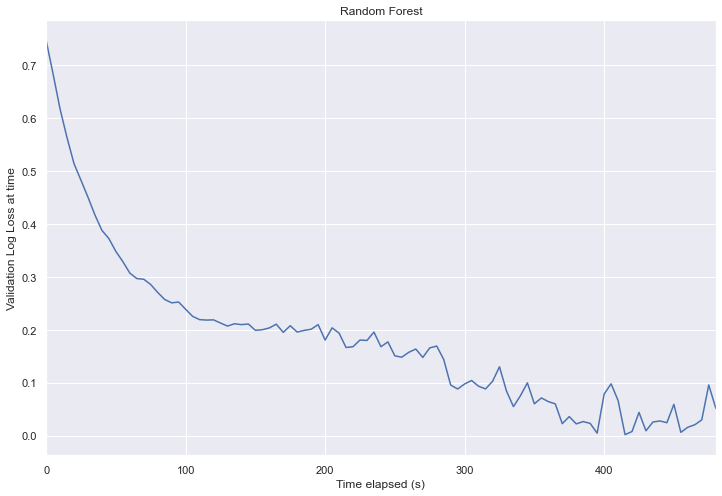

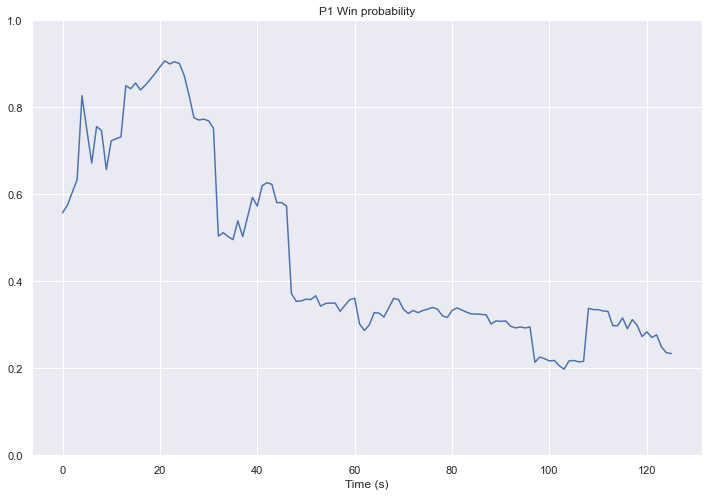

In [62]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_features=5)
rf=validate_model(rf,X_train, y_train, X_val, y_val, xgb=False, title='Random Forest')
plot_win_probs(prob_check,rf, features)

3 XGBoost

Training accuracy: 0.959
Training log loss: 0.157
Validation accuracy: 0.886
Validation log loss: 0.261


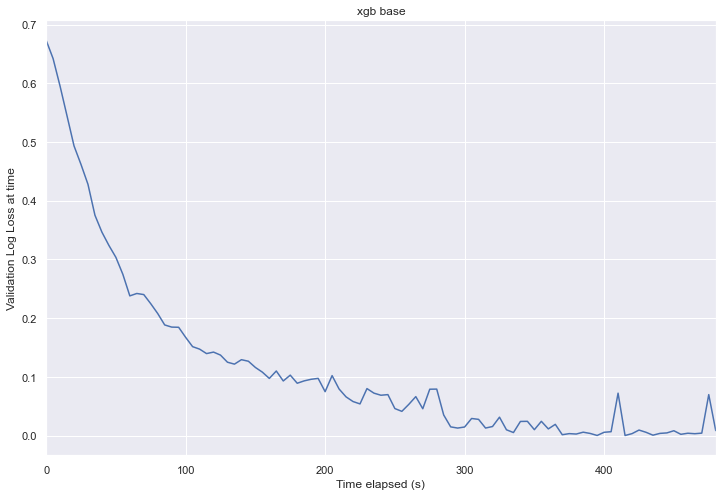

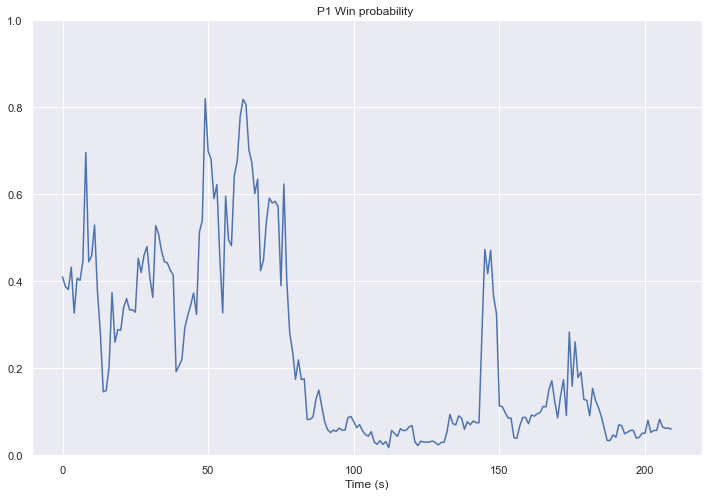

In [147]:
xg = xgb.XGBClassifier(n_jobs = -1, 
                        objective='binary:logistic', 
                        use_label_encoder=False,
                       gamma = .75,
                       n_estimators = 500,
                       reg_alpha=0.5,
                       reg_lambda = 2,
                       max_depth=10,
                       eta = .15
                       )

xg=validate_model(xg,X_train, y_train, X_val, y_val, xgb=True, title='xgb base')
plot_win_probs(prob_check3,xg, features)

Got a better log loss with XGBoost, but not sure if I like how the XGBoost proability graphs look though:

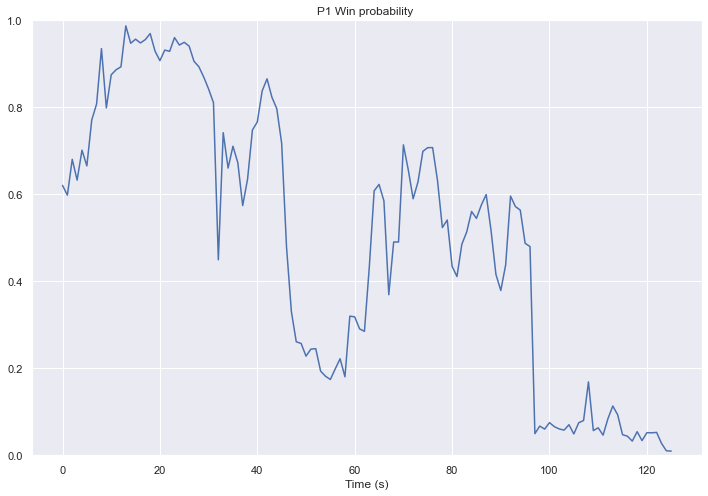

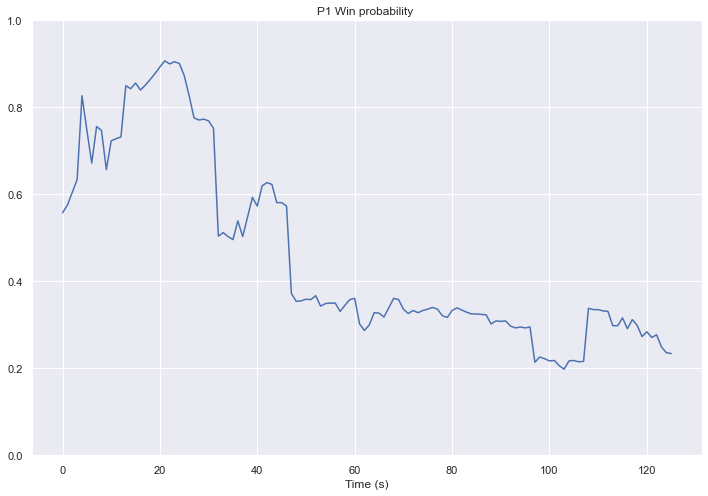

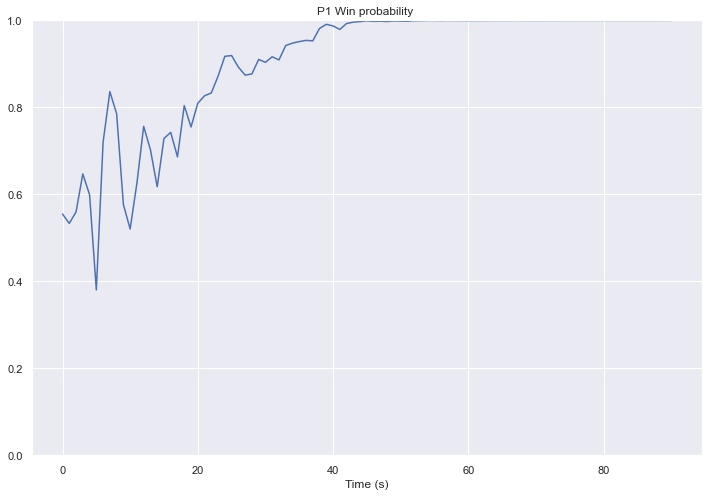

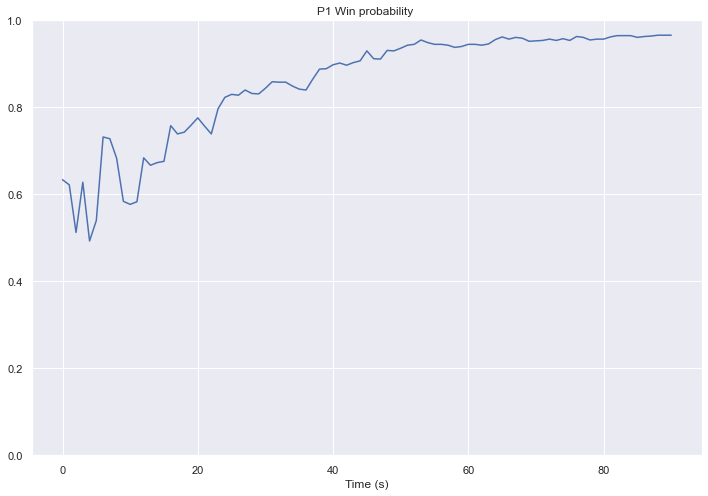

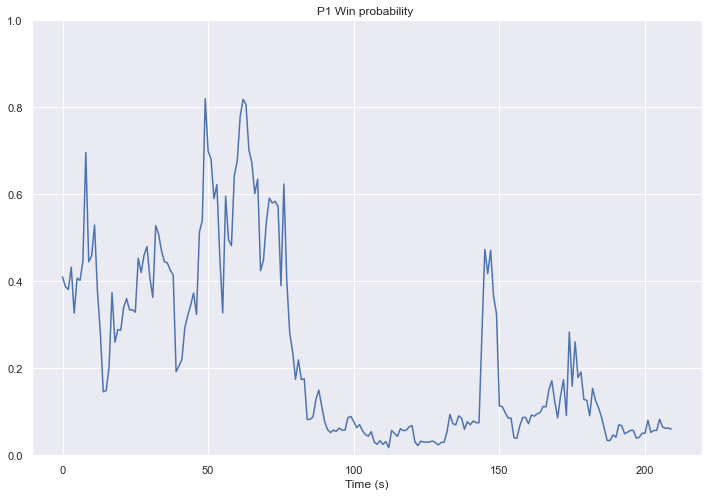

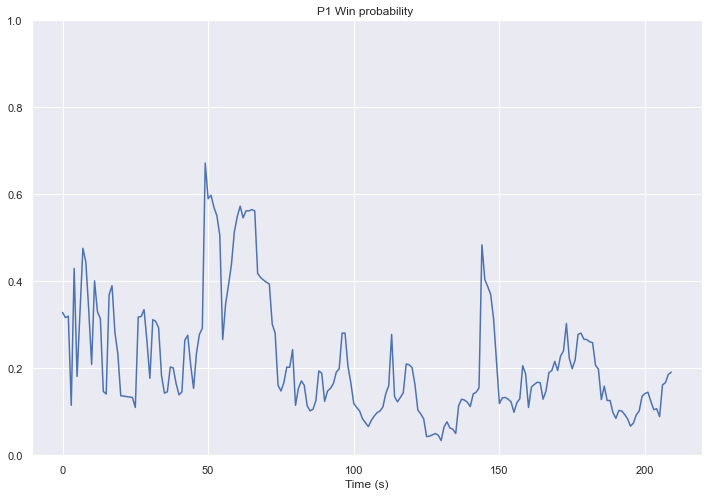

In [67]:
plot_win_probs(prob_check,xg, features)
plot_win_probs(prob_check,rf, features)
plot_win_probs(prob_check2,xg, features)
plot_win_probs(prob_check2,rf, features)
plot_win_probs(prob_check3,xg, features)
plot_win_probs(prob_check3,rf, features)

XGBoost tends to make swingier probability graphs - odds can go up to 1 and down to 0. I guess it's doing a good enough job that this does decrease the overall log loss, but at the cost of prob graphs that imo look worse for telling a story

## Only using FP9 and GS 

In [69]:
gs_5s_igs = pd.read_pickle('saved_data/gs_5s_igs.pkl')
fp9_5s_igs=pd.read_pickle('saved_data/fp9_5s_igs.pkl')
df2,features = process_df_igs(pd.concat([gs_5s_igs, fp9_5s_igs]).reset_index(drop=True))

In [70]:
df_train2, df_test2 = train_test_split(df2, test_size=0.25, random_state=42)
df_train2, df_val2 = train_test_split(df_train2, test_size=0.2, random_state=42)

X_train2 = df_train2[features]
y_train2 = df_train2['winner']

X_val2 = df_val2[features]
y_val2 = df_val2['winner']

X_test2 = df_test2[features]
y_test2 = df_test2['winner']

In [49]:
prob_check = construct_df_igs(['replays/mangozain.slp'],1)
prob_check,all_diff_feats = process_df_igs(prob_check)
prob_check2 = construct_df_igs(['replays/4stockp1.slp'],1)
prob_check2,all_diff_feats = process_df_igs(prob_check2)
prob_check3 = construct_df_igs(['replays/test.slp'],1)
prob_check3,all_diff_feats = process_df_igs(prob_check3)

Games parsed: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Training accuracy: 0.991
Training log loss: 0.100
Validation accuracy: 0.911
Validation log loss: 0.292


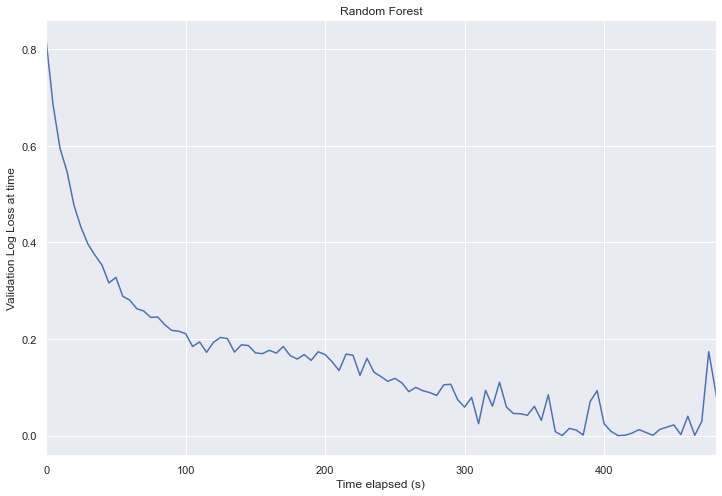

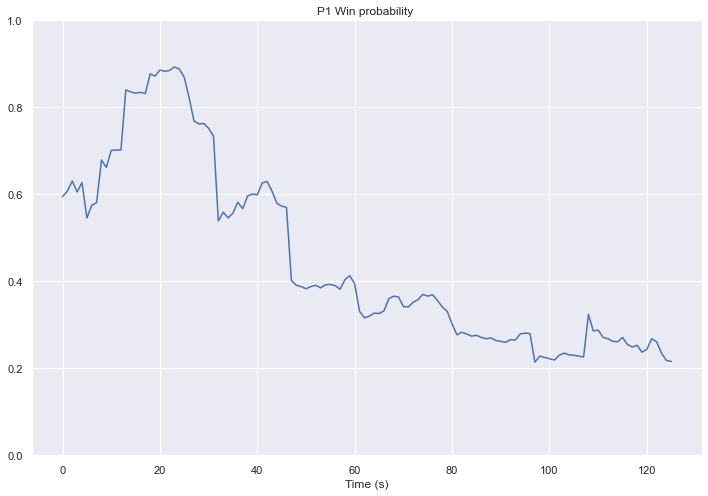

In [71]:
rf2 = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_features=5)
rf2=validate_model(rf2,X_train2, y_train2, X_val2, y_val2, xgb=False, title='Random Forest')
plot_win_probs(prob_check,rf2, features)

Training accuracy: 0.868
Training log loss: 0.308
Validation accuracy: 0.841
Validation log loss: 0.345


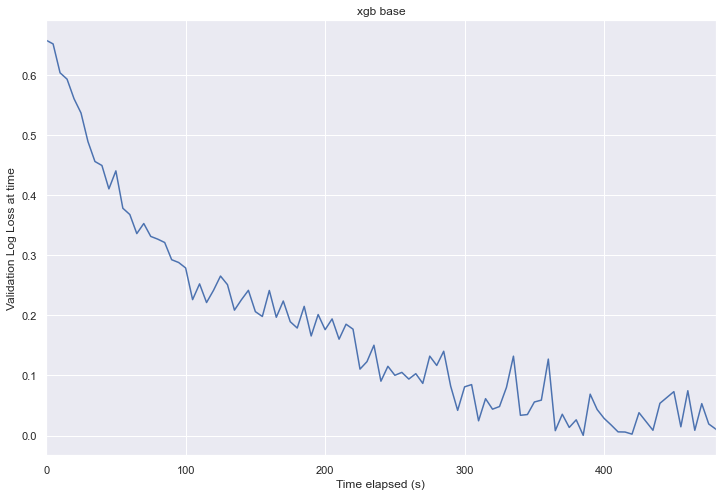

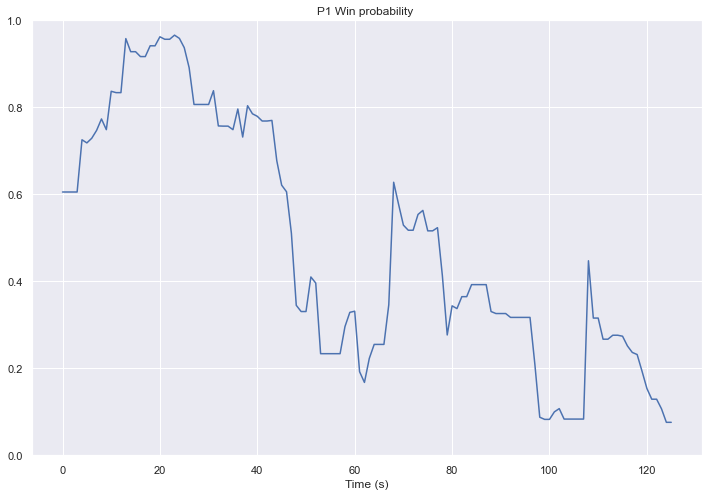

In [72]:
xg_base2 = xgb.XGBClassifier(n_jobs = -1, 
                        objective='binary:logistic', 
                        use_label_encoder=False
                       )

xg_base2=validate_model(xg_base2,X_train2, y_train2, X_val2, y_val2, xgb=True, title='xgb base')
plot_win_probs(prob_check,xg_base2, features)

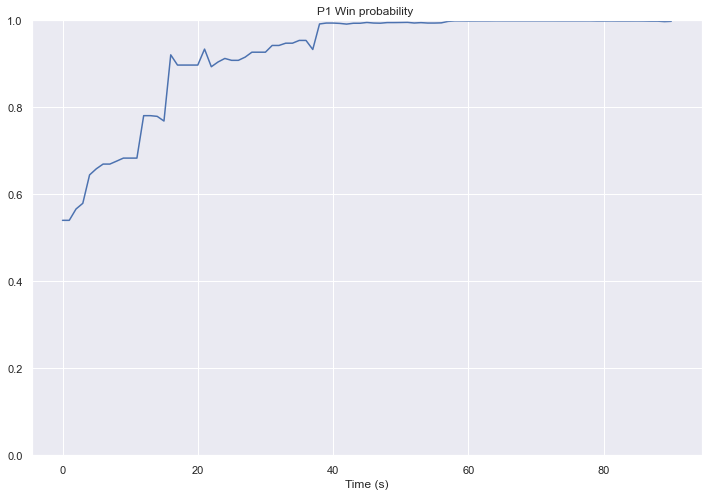

In [74]:
plot_win_probs(prob_check2,xg_base2, features)


A base XGBoost model has pretty low log loss, so it seems like tuning may help get it down before RF. But it seems like XGBoost is more bullish 

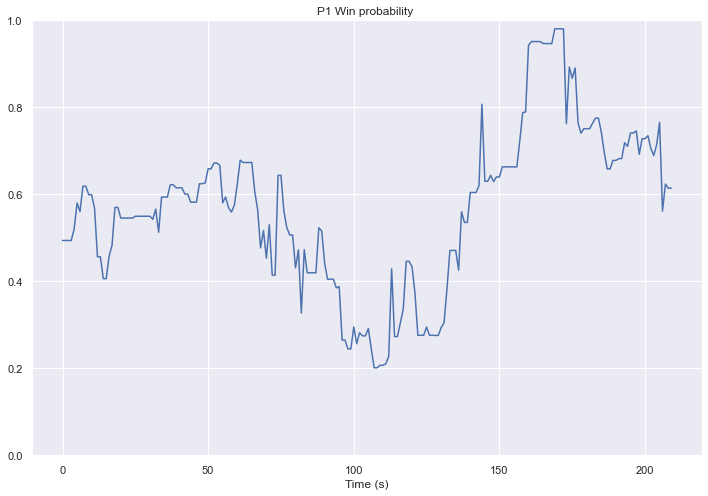

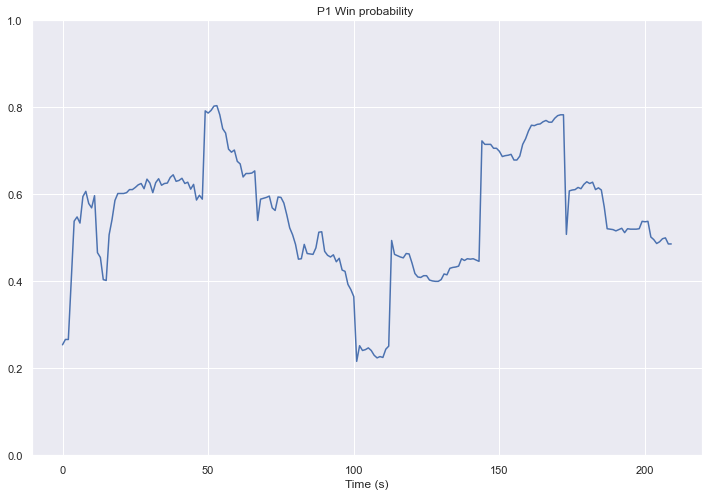

In [75]:
plot_win_probs(prob_check3,xg_base2, features)
plot_win_probs(prob_check3,rf2, features)

Training accuracy: 0.986
Training log loss: 0.073
Validation accuracy: 0.929
Validation log loss: 0.175


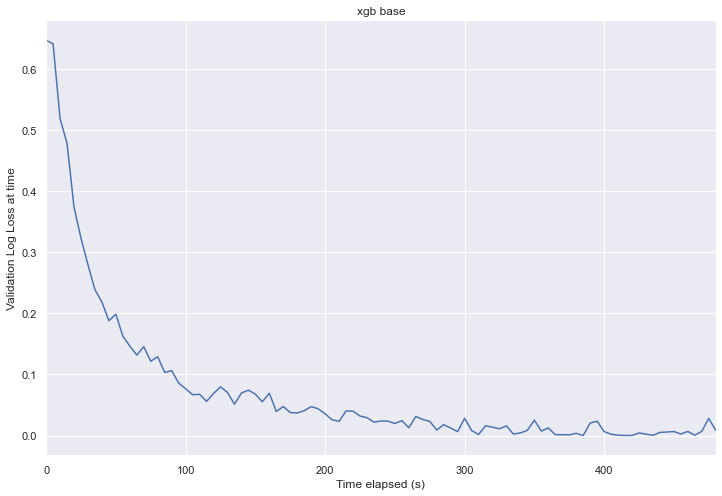

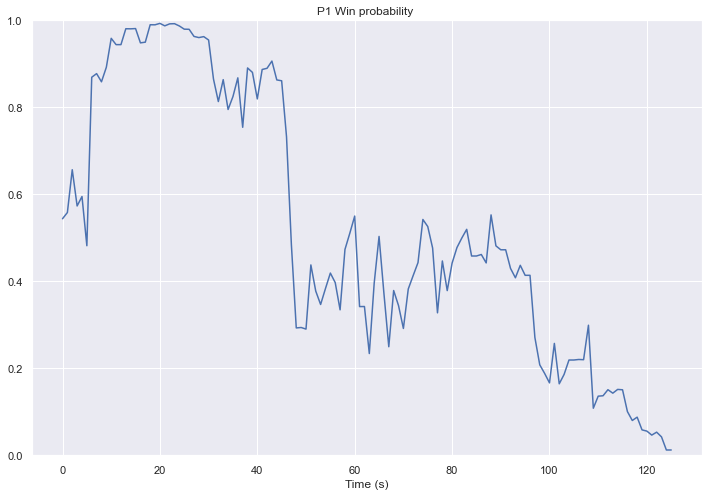

In [76]:
xg2 = xgb.XGBClassifier(n_jobs = -1, 
                        objective='binary:logistic', 
                        use_label_encoder=False,
                       gamma = .75,
                       n_estimators = 500,
                       reg_alpha=0.5,
                       reg_lambda = 2,
                       max_depth=10,
                       eta = .15
                       )

xg2=validate_model(xg2,X_train2, y_train2, X_val2, y_val2, xgb=True, title='xgb base')
plot_win_probs(prob_check,xg2, features)

Got a better log loss with XGBoost, but not sure if I like how the XGBoost proability graphs look

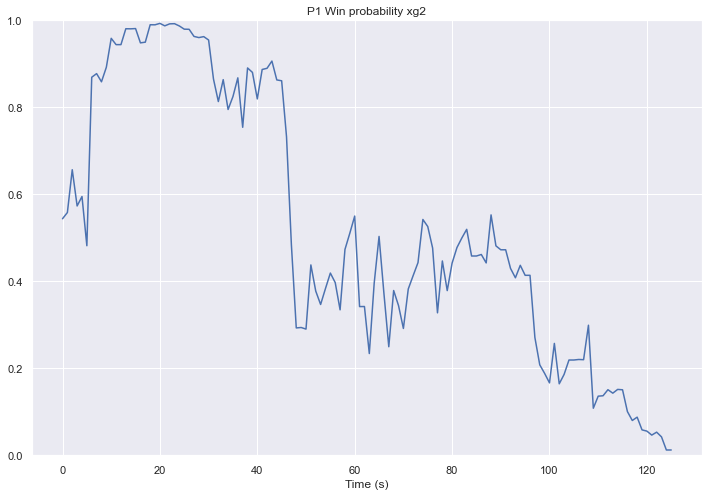

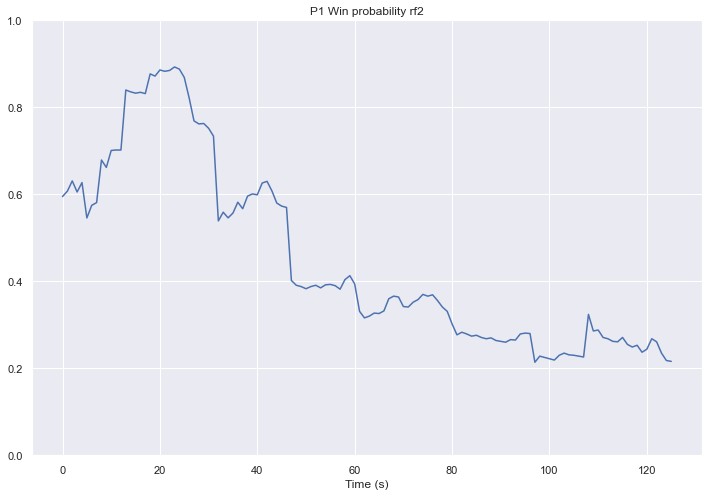

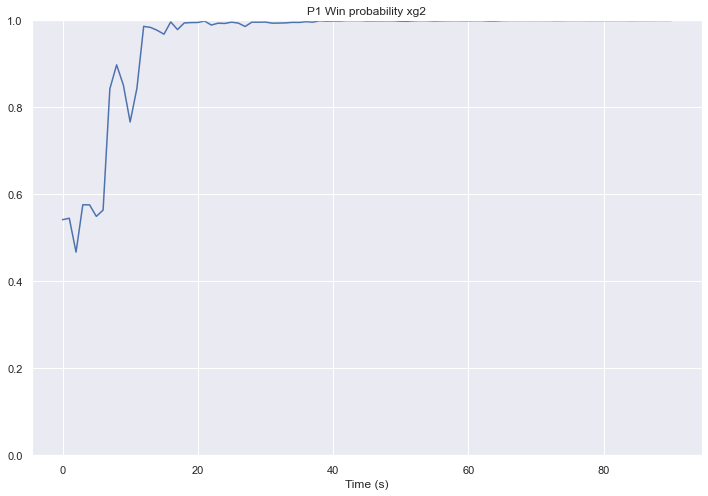

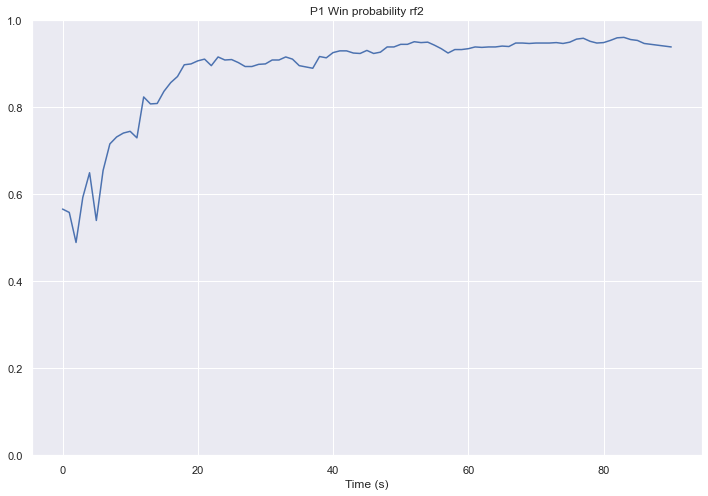

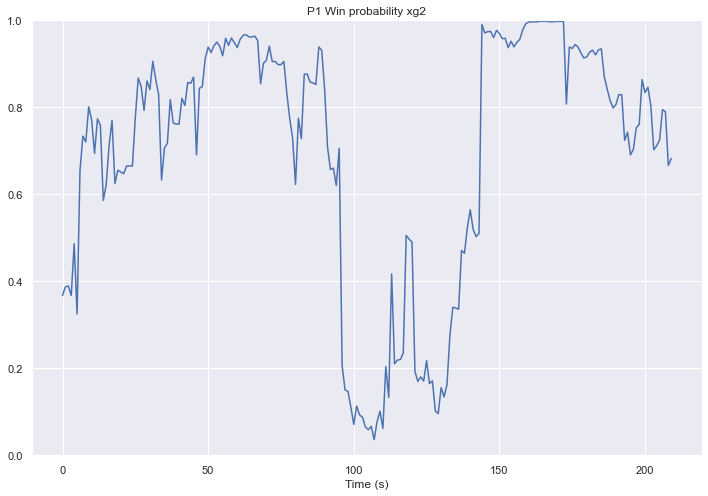

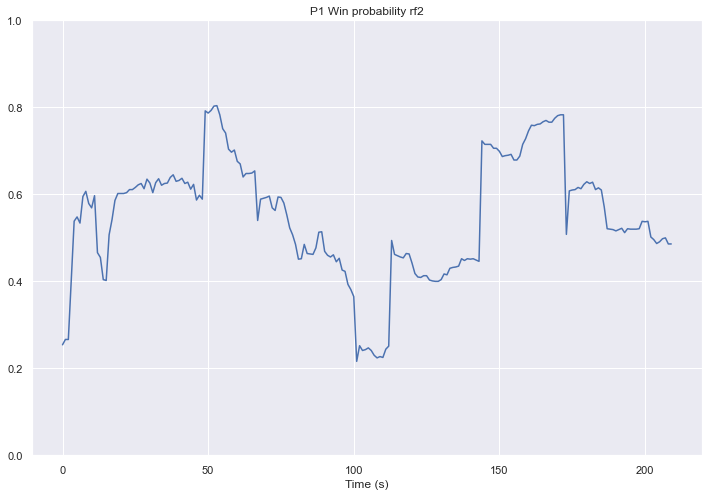

In [79]:
plot_win_probs(prob_check,xg2, features,'xg2')
plot_win_probs(prob_check,rf2, features,'rf2')
plot_win_probs(prob_check2,xg2, features,'xg2')
plot_win_probs(prob_check2,rf2, features,'rf2')
plot_win_probs(prob_check3,xg2, features,'xg2')
plot_win_probs(prob_check3,rf2, features,'rf2')

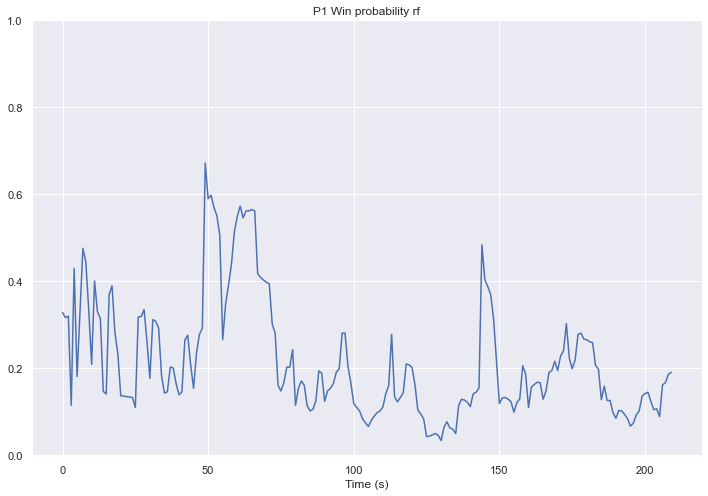

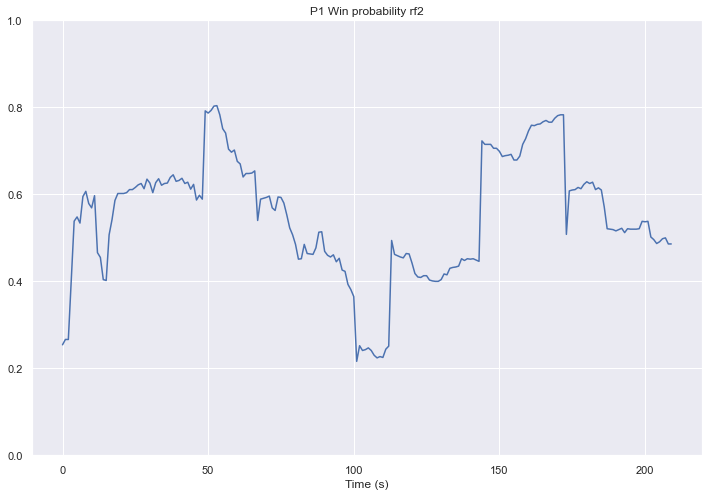

In [81]:
plot_win_probs(prob_check3,rf, features,'rf')
plot_win_probs(prob_check3,rf2, features,'rf2')

Not sure what I think about this - this is the same game with the same model but with different training data. I'm inclined to think the bottom on is more correct because the game is close, but maybe the model is picking up on something that I'm not even thinking of.

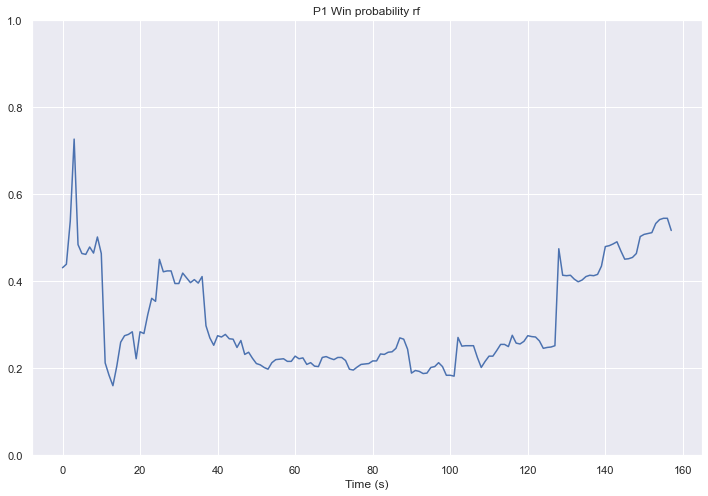

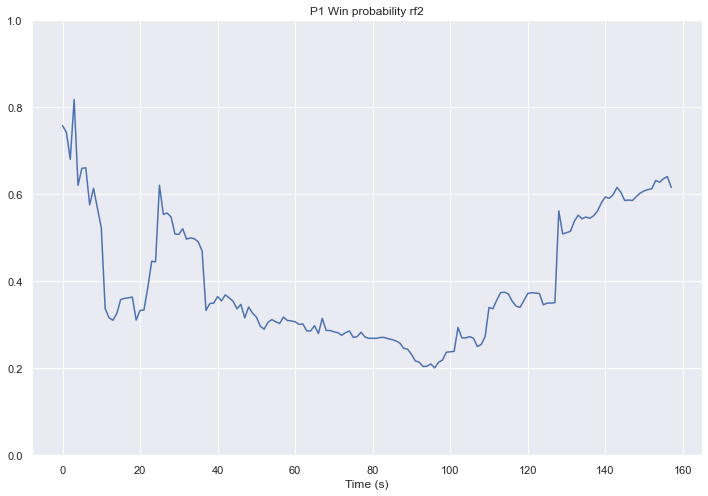

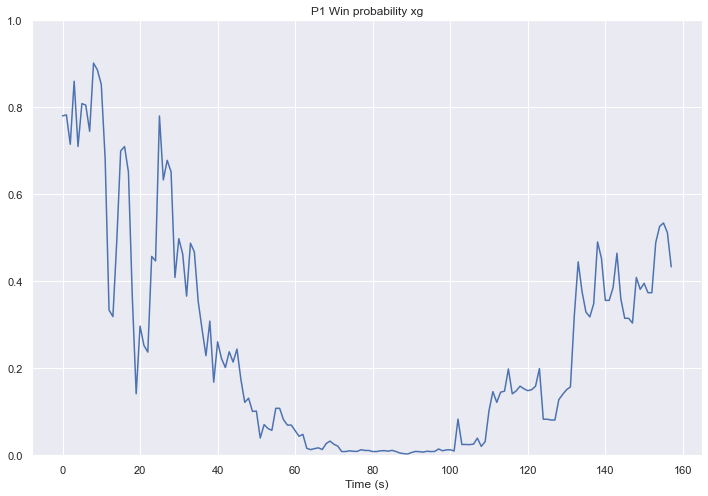

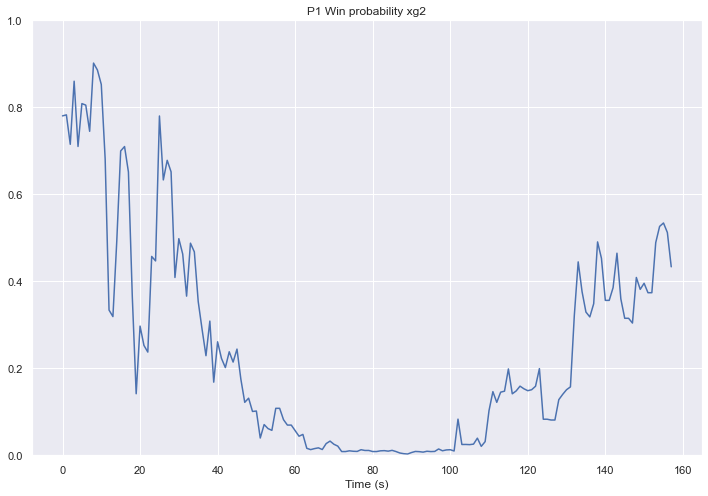

In [83]:
plot_win_probs(prob_check4,rf, features,'rf')
plot_win_probs(prob_check4,rf2, features,'rf2')

plot_win_probs(prob_check4,xg, features,'xg')
plot_win_probs(prob_check4,xg2, features,'xg2')

This one looks a bit better. Its a close game wher p1 mounts a mini comeback but then doesnt win

## Extratrees

Training accuracy: 0.989
Training log loss: 0.019
Validation accuracy: 0.927
Validation log loss: 0.286


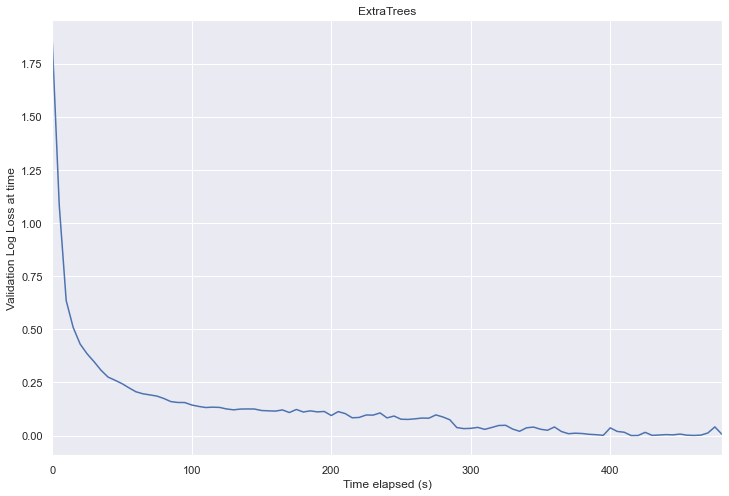

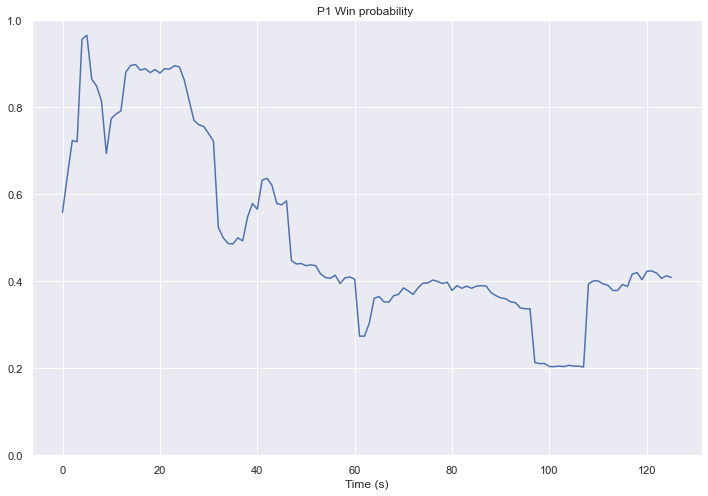

In [101]:
xt = ExtraTreesClassifier(n_jobs=-1, n_estimators=1000)
xt=validate_model(xt,X_train, y_train, X_val, y_val, xgb=False, title='ExtraTrees')
plot_win_probs(prob_check,xt, features)

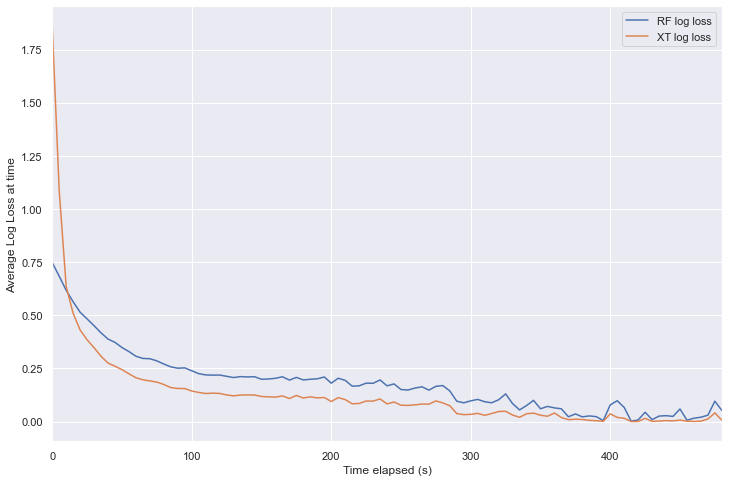

In [102]:
plot_multiple_log_loss(X_val, y_val, [rf,xt],['RF', 'XT'])

Intersting - looks like ExtraTrees (extreme random forest) overall performs a bit better than rf, except at the beginning. Lets try tuning the model a bit to see if we can fix that

Training accuracy: 0.988
Training log loss: 0.085
Validation accuracy: 0.925
Validation log loss: 0.262


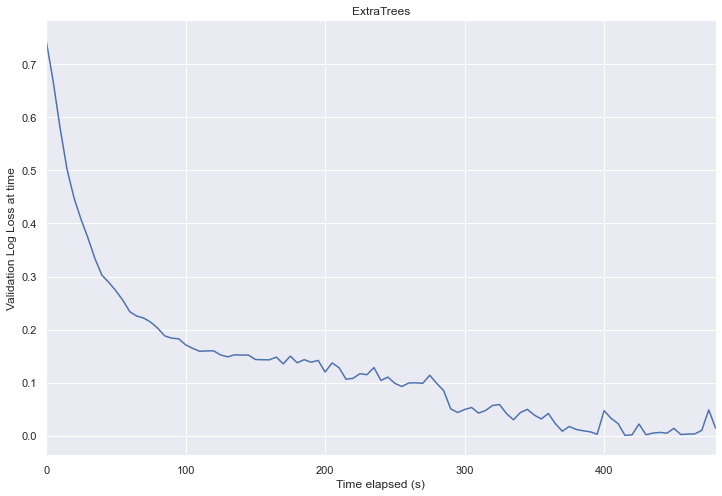

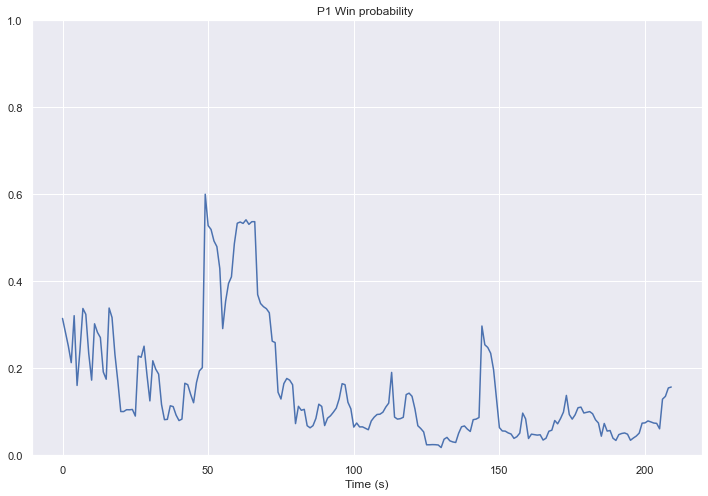

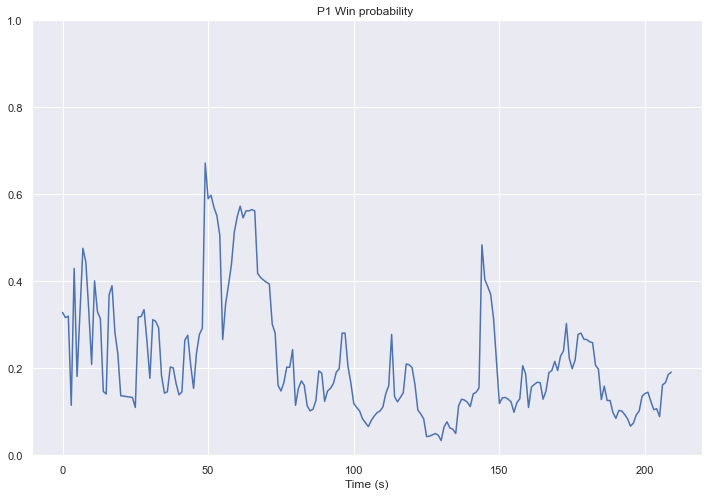

In [151]:
xt = ExtraTreesClassifier(n_jobs=-1, n_estimators=1000,ccp_alpha=.000001, max_features = 'log2', min_samples_split=4)

xt=validate_model(xt,X_train, y_train, X_val, y_val, xgb=False, title='ExtraTrees')
plot_win_probs(prob_check3,xt, features)
plot_win_probs(prob_check3,rf, features)

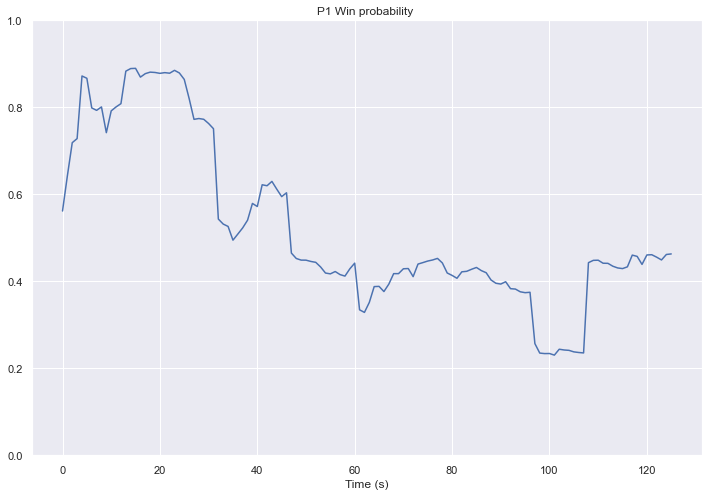

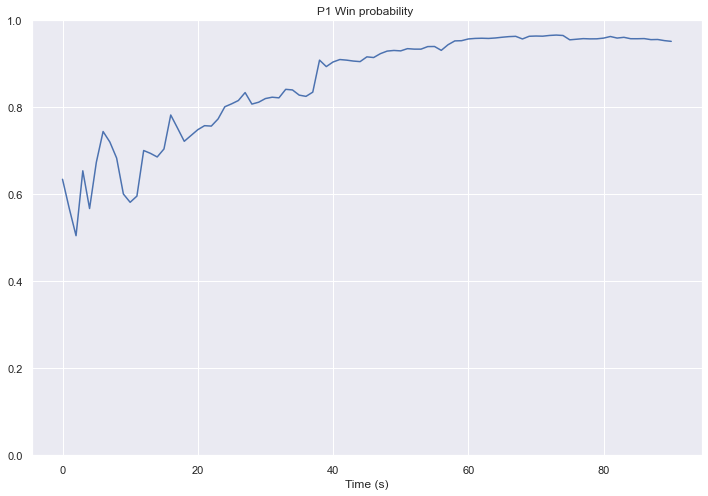

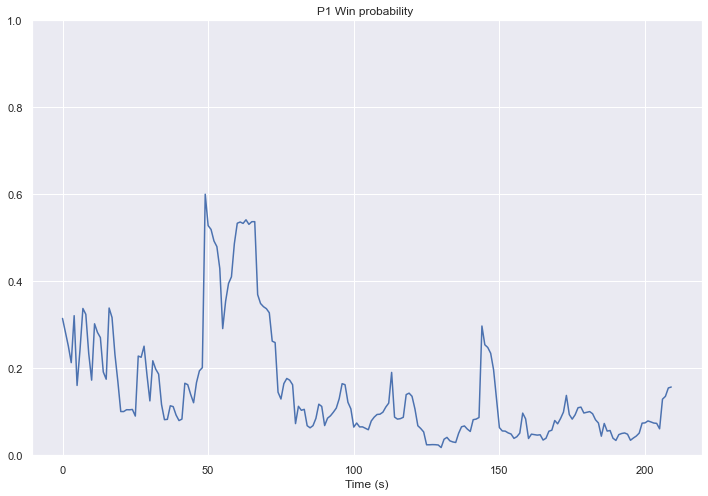

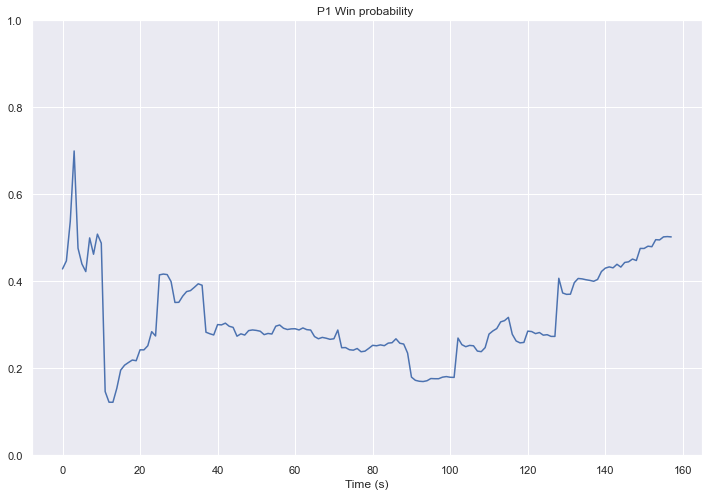

In [152]:
plot_win_probs(prob_check, xt, features)
plot_win_probs(prob_check2,xt, features)
plot_win_probs(prob_check3,xt, features)
plot_win_probs(prob_check4,xt, features)

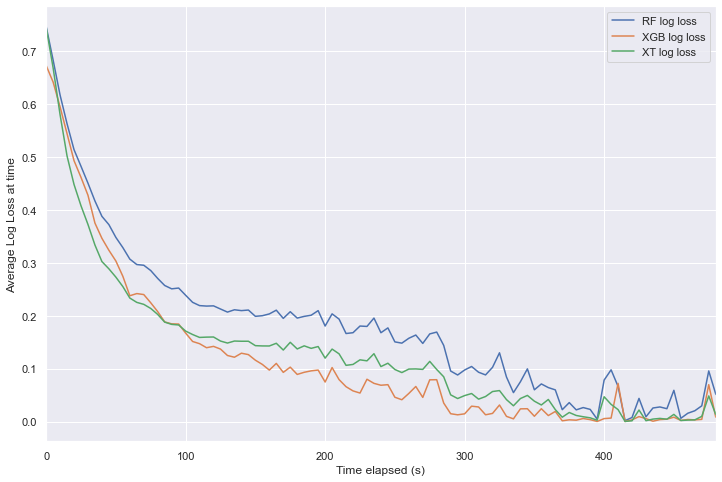

In [153]:
plot_multiple_log_loss(X_val, y_val, [rf,xg,xt],['RF','XGB', 'XT'])

It seems like after tuning extratrees is able to narrow the gap at the beginning with RF. It also performs on par with XGBoost, which is a major plus for interpretability. I think the probability graphs mostly make sense as well

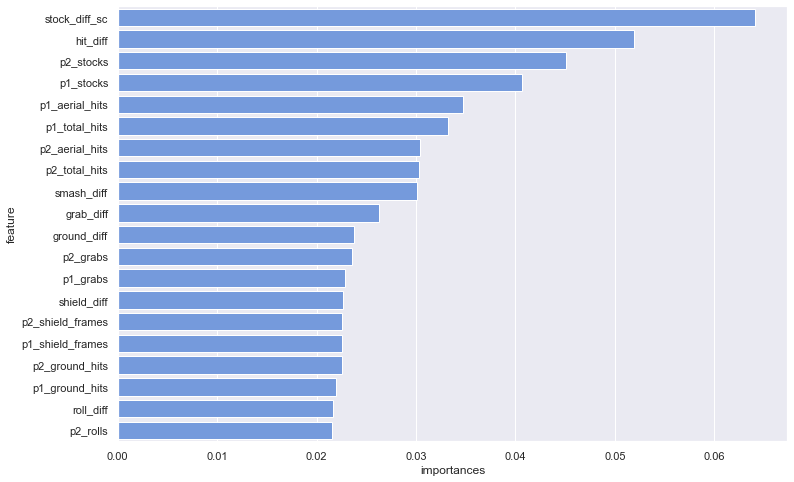

In [136]:
plot_feature_importances(xt, features, 20)

In [154]:
gs_5s_igs = pd.read_pickle('saved_data/gs_5s_igs.pkl')
fp9_5s_igs=pd.read_pickle('saved_data/fp9_5s_igs.pkl')
df2,features = process_df_igs(pd.concat([gs_5s_igs, fp9_5s_igs]).reset_index(drop=True))
df_train2, df_test2 = train_test_split(df2, test_size=0.25, random_state=42)

X_train2 = df_train2[features]
y_train2 = df_train2['winner']

X_test2 = df_test2[features]
y_test2 = df_test2['winner']

In [155]:
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

In [161]:
clf = ExtraTreesClassifier(random_state=0,ccp_alpha=.000001 )
param_grid = {"max_depth": [10,20,30, None],
              "min_samples_split": [2,5, 10],
              "max_features": [2,5,10,None],
              "min_impurity_decrease": [0, .0001]}
search = HalvingGridSearchCV(clf, param_grid, resource='n_estimators',
                             max_resources=200,scoring='neg_log_loss',
                             random_state=0).fit(X_train2, y_train2)

In [162]:
print(search.best_params_  )
print(search.best_score_)


{'max_depth': None, 'max_features': 5, 'min_impurity_decrease': 0, 'min_samples_split': 10, 'n_estimators': 162}
-0.28294945164837765
